## Step 0: Importing the Appropriate Packages

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import emcee
import corner
import os
import glob

import astropy.constants as ac
from astropy import units as u
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.modeling import models
from astropy.visualization import quantity_support
from scipy.optimize import minimize
from scipy import interpolate

## Step 1: Importing Data and Changing the Units of the Variables

We'll first import and read the following data:

1. chen+07_slshlh.dat; This contains the Spitzer IRS spectrum of BetaPic from ~5-35 microns. 

2. betapic_fluxes.dat; This contains assorted photometry from the optical and infrared with BetaPic. 

3. betapic_lws_cnt3_.txt; This contains the ISO LWS spectrum of BetaPic, from ~43 to 160 microns.

### 1.1: Using the correct folders to pull the data from and to put the data in

In [13]:
# to change to main directory
os.chdir('..')
cwd = os.getcwd()

# then the appropriate folders inside this main directory
Photom_IRS = cwd + "\\data\\betapic_data\DiskModels\Debris\BetaPic" # where the photometry and IRS Spectrum is found
LWS = cwd + "\\data\\betapic_data\DiskModels\Debris\BetaPic\iso\hpdp_62003530_3" # where the LWS Spectrum is found

Ice = cwd + "\\data\\water_ice_opacities_lsbrp" # where the different opacity files are found
Silicates = cwd + "\\data\\silicates_for_betapic" # where the different silicate files are found

### 1.2: Importing the Data 

In [14]:
# Changing directory to the photometry and IRS Spectrum files
os.chdir(Photom_IRS)

# Columns are all labelled (wavelength in microns, flux (F_nu) and uncertainty in Janskys, (Jy)).
Spitzer_IRS = np.loadtxt('chen+07_slshlh.dat')
Wavelength_IRS, Flux_IRS_Jy, Error_IRS_Jy = Spitzer_IRS[:,0], Spitzer_IRS[:,1], Spitzer_IRS[:,2]

# Columns are formatted as wavelength (mircons), flux (F_nu, Jy), uncertainty (Jy).
Photom = np.loadtxt('betapic_fluxes.dat')
Wavelength_Photom, Flux_Photom_Jy, Error_Photom_Jy = Photom[:,0], Photom[:,1], Photom[:,2]


# Changing directory to the LWS Spectrum file
os.chdir(LWS)

# Columns are formatted  as wavelength (microns), nu*F_nu (erg/cm^2/s), and uncertainty in nu*F_nu (same units).
ISO_LWS = np.loadtxt('betapic_lws_cnt3_.txt')
Wavelength_LWS, Flux_LWS, Error_LWS = ISO_LWS[:,0], ISO_LWS[:,1], ISO_LWS[:,2]

### 1.3: Rewriting the units
We need to convert the fluxes and error from Jansky to erg cm$^{-2}$ s$^{-1}$ . We know that 1 Jy equals to 10$^{23}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$.

Such that we get: erg cm$^{-2}$ s$^{-1}$ = 10$^{-23}$ Hz Jy

In [15]:
# We can now calculate the flux using F = v*F_v (also making sure that the wavelength is in meters and not in microns)
Flux_IRS = 10**(-23)*Flux_IRS_Jy*(ac.c.value/(Wavelength_IRS*10**(-6)))
Flux_Photom = 10**(-23)*Flux_Photom_Jy*(ac.c.value/(Wavelength_Photom*10**(-6)))

# We can now also calculate the error in the fluxes
Error_IRS = 10**(-23)*Error_IRS_Jy*(ac.c.value/(Wavelength_IRS*10**(-6)))
Error_Photom = 10**(-23)*Error_Photom_Jy*(ac.c.value/(Wavelength_Photom*10**(-6)))

In [16]:
# Making sure no flux is zero/negative
Flux_IRS, Wavelength_IRS, Error_IRS = Flux_IRS[Flux_IRS>0], Wavelength_IRS[Flux_IRS>0], Error_IRS[Flux_IRS>0]
Flux_Photom, Wavelength_Photom, Error_Photom = Flux_Photom[Flux_Photom>0], Wavelength_Photom[Flux_Photom>0], Error_Photom[Flux_Photom>0]

# Removing the negative values
Flux_LWS, Wavelength_LWS, Error_LWS = Flux_LWS[Flux_LWS>0], Wavelength_LWS[Flux_LWS>0], Error_LWS[Flux_LWS>0]

# Removing the error equal to 0 from the photometry
Error_Photom, Flux_Photom, Wavelength_Photom = Error_Photom[Error_Photom!=0], Flux_Photom[Error_Photom!=0], Wavelength_Photom[Error_Photom!=0]

We need to convolve LWS Spectrum to smoothen it

In [17]:
# Create kernel & convolving lWS spectrum
g = Gaussian1DKernel(stddev=3)
z = convolve(Flux_LWS, g)

# Removing the tail of the LWS spectrum [by trial and error]
Wavelength_z, z, Error_z = Wavelength_LWS[6:], z[6:], Error_LWS[6:]

In [18]:
# Creating a list with all ice opacity file names
os.chdir(Ice)
ice = sorted(glob.glob("h2oice.p3p5.amin0p005.amax*.wb08c146"))

# Columns have the format: wavelength (microns), total opacity, albedo, absorption coefficient, asymmetry parameter g
# Read the files in with np.loadtxt('filename')

# Creating a list with all silicate opacity file names
os.chdir(Silicates)
silicates = sorted(glob.glob("sil.p3p5.amax*.extinc"))

# Returning to main directory
os.chdir(cwd)

## MCMC Fit

In [19]:
def tau(kappa, mass, d):
    return kappa*(mass*(ac.M_earth).value*10**(3))/(d**2)

def chi_sq(model, flux, error):
    """Calculates the chi squared value."""
    return np.sum(((model-flux)/error)**2)

def spectrum_ice_si(wave, x_b, x_d,  kappa_ice, kappa_si, d):
    """Creates a model for the flux of a star, for which a blackbody approximation is used,
    in combination with a ring for which both ice and silicates opacities are
    taken into account."""
    T, SolidAngle = x_b
    T_2, mass_i, mass_s = x_d
    
    bb = models.BlackBody(temperature=T*u.K)
    B_q_1 = bb(wave*u.micron)
    bb_2 = models.BlackBody(temperature=T_2*u.K)
    B_q_2 = bb_2(wave*u.micron)
    
    t_ice = tau(kappa_ice, mass_i*10**(-4), d)/0.0005
    t_si = tau(kappa_si, mass_s*10**(-2), d)/0.004
        
    F_1 = (SolidAngle)*B_q_1*(ac.c/(wave*u.micron))
    F_2 = B_q_2*(ac.c/(wave*u.micron))
    
    F = F_1 + (t_ice + t_si)*F_2
    return F.to(u.erg * u.cm**(-2) * u.s**(-1) * u.sr**(-1)).value

def chi_squared_ice_si(x0, wave, x0_beta, flux_ISO, error_ISO, d, kappa_ice, kappa_si):
    """Calculates the reduced chi^2 value for a given set of parameters and data points
    (with the corresponding errors) for a certain model. This definition is for the 
    the determination of the reduced chi^2 value of the flux of a model."""
    for i in x0:
        if i < 0:
            return np.inf
    
    f_ice = interpolate.interp1d(kappa_ice[:,0], kappa_ice[:,1])
    f_si = interpolate.interp1d(kappa_si[:,0], kappa_si[:,1])
    kappa_ice, kappa_si = f_ice(wave), f_si(wave)
    
    model = spectrum_ice_si(wave, x0_beta, x0, kappa_ice, kappa_si, d)
    chi = chi_sq(model, flux_ISO, error_ISO)
    return chi/(len(model))

In [20]:
def lnL(x0, wave, x0_beta, flux_ISO, error_ISO, d, ice, si):
    """Calculates the ln of the likelihood from the parameters and data points."""   
    chi = chi_squared_ice_si(x0, wave, x0_beta, flux_ISO, error_ISO, d, ice, si)
    return -chi/2

def ln_prior(x0, x0_guess, sigma):
    """Calculates the prior from the parameters, an initial guess for these paramters, 
    and some deviations for the parameters (sigma)."""
    T_2, Mass_Ice, Mass_Si = x0
    T_2_g, Mass_Ice_g, Mass_Si_g = x0_guess
    sig_T_2, sig_Mass_Ice, sig_Mass_Si = sigma
    
    prior_T = np.exp(-(T_2-T_2_g)**(2)/2 * sig_T_2**(2))
    prior_M_Ice = np.exp(-(Mass_Ice*10**(-4) - Mass_Ice_g*10**(-4))**2 / (2 * (sig_Mass_Ice*10**(-4))**2))
    prior_M_Si = np.exp(-(Mass_Si*10**(-2)-Mass_Si_g*10**(-2))**(2)/2 * (sig_Mass_Si*10**(-2))**(2))

    return prior_T * prior_M_Ice * prior_M_Si

def ln_prob(x0, x0_guess, sigma, wave, x0_beta, flux_ISO, error_ISO, d, ice, si):
    """Calculates the likelihood to include in the MCMC calculations."""   
    lp = ln_prior(x0, x0_guess, sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(x0, wave, x0_beta, flux_ISO, error_ISO, d, ice, si)

### Setting Up the Variables for the MCMC Simulation

In [21]:
# Set up the properties of the problem. We want to fit ndim parameters with a certain amount of walkers
ndim, nwalkers = 3, 2000

# Guess at a solution
x0_guess = [7.83099651e+01, 1.96042592, 1.34327379] #[e0 , e-4 , e-2] - From Part 1 Chi Squared
sigma = [10, 0.5, 0.5]

fit_mask_LWS = ( (Wavelength_z <= 120) )

x0_BetaPic = [8200, 1.2699*10**(-17)]
d_BetaPic = (19.76*u.pc).to(u.cm).value

ice_file = 'h2oice.p3p5.amin0p005.amax15.g.ab0p0005.wb08c146' # - From Part 1 Chi Squared
silicates_file = 'sil.p3p5.amax1mm.g.ab0p004.extinc'


os.chdir(Ice)
Ice_Best = np.loadtxt(ice_file,skiprows=1)

os.chdir(Silicates)
Silicate_Best = np.loadtxt(silicates_file,skiprows=1)

### Running the MCMC Simulation

In [22]:
os.chdir(cwd)
pos = [x0_guess + 1e-14*np.random.randn(ndim) for i in range(nwalkers)]

# Create the sampler. 
sampler_final = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=(x0_guess, sigma, Wavelength_z[fit_mask_LWS], x0_BetaPic,  
                                                                     z[fit_mask_LWS], Error_z[fit_mask_LWS], d_BetaPic,
                                                                     Ice_Best, Silicate_Best))

tmp = sampler_final.run_mcmc(pos, 300, progress = True)

 41%|████▏     | 124/300 [28:03<31:53, 10.87s/it] C:\Users\SPJHe\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\SPJHe\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 300/300 [58:13<00:00, 11.64s/it]


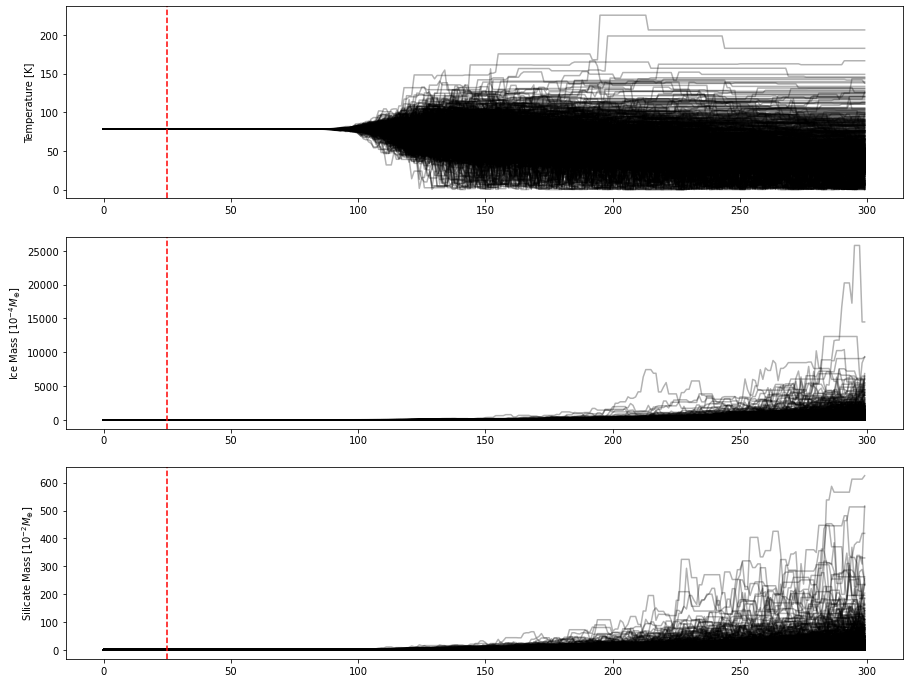

In [23]:
# Plot the walkers to cut off the burn-in time

burnin = 25

fig, axes = plt.subplots(ncols = 1, nrows = ndim)
fig.set_size_inches(15,12)

axes[0].plot(sampler_final.chain[:, :, 0].transpose(), color = 'black', alpha = 0.3)
axes[0].set_ylabel('Temperature [K]')
axes[0].axvline(burnin, ls='dashed', color = 'red')
axes[1].plot(sampler_final.chain[:, :, 1].transpose(), color = 'black', alpha = 0.3)
axes[1].set_ylabel('Ice Mass [$10^{-4} M_{\oplus}$]')
axes[1].axvline(burnin, ls='dashed', color = 'red')
axes[2].plot(sampler_final.chain[:, :, 2].transpose(), color = 'black', alpha = 0.3)
axes[2].set_ylabel('Silicate Mass [$10^{-2} M_{\oplus}$]')
axes[2].axvline(burnin, ls='dashed', color = 'red')

plt.show()
plt.close()

### Making a Corner Plot to See the Results

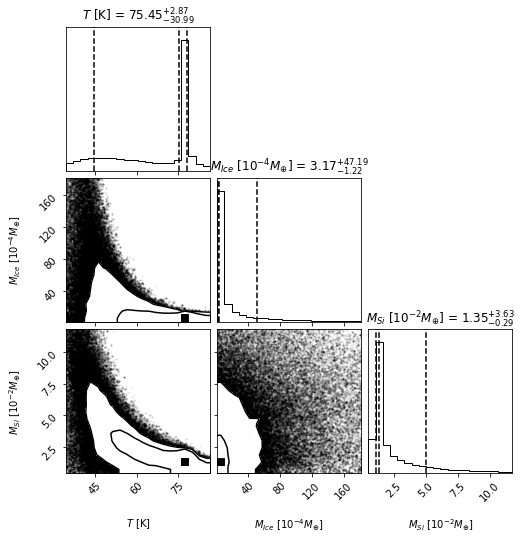

In [24]:
# Making sure that the figure will be saved in the main directory
os.chdir(cwd)

# Finally, we make a corner plot of everything
samples_final = sampler_final.chain[:, burnin:265, :].reshape((-1, ndim))

fig = corner.corner(samples_final, labels = ["$T$ [K]","$M_{Ice}$ [$10^{-4} M_{\oplus}$]",
                                             "$M_{Si}$ [$10^{-2} M_{\oplus}$]"], 
                    quantiles = [0.16, 0.5, 0.84], show_titles = True, title_kwargs={"fontsize": 12},
                    range = (.9, .9, .9)) 

plt.show()
plt.close()

In [26]:
print("T:", np.median(samples_final[:,0]),"K")
print("$M_{Ice}$:", np.median(samples_final[:,1]),"e-4 $M_{\oplus}$$")
print("$M_{Si}$:", np.median(samples_final[:,2]),"e-2 $M_{\oplus}$$")

T: 75.45373752445839 K
$M_{Ice}$: 3.17482203758067 e-4 $M_{\oplus}$$
$M_{Si}$: 1.346394551322205 e-2 $M_{\oplus}$$
